# Importing Libraries

This is useful to build the Model and to use the performance metrics for evaluation. These are all the necessary imports required for this Notebook

In [9]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
!ls "/content/drive/My Drive/"

'AI on Spectrum - Web ML'	     MIL
'Colab Notebooks'		    'Task Completion results (1).gsheet'
 Dataset			    'Task Completion results (2).gsheet'
 Deep-Learning			    'Task Completion results (3).gsheet'
 DL-Labs			    'Task Completion results (4).gsheet'
'Dragon Booster 1-39'		    'Task Completion results.gsheet'
'Getting started.pdf'		    'Untitled document.gdoc'
'Master of Information Technology'


In [11]:
import tensorflow as tf
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import cv2
import itertools

# To randomly shuffle the data
import random

# To split the data in train and test sets
# and to convert them into categeorical values
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

#Accuracy with the test data
# demonstration of calculating metrics for a neural network model using sklearn
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

# To generate the classification report 
from sklearn.metrics import classification_report

# To check the version of the tensorflow
tf.__version__

# Declaring a constants for classififer
SIZE_OF_IMAGE = 48
BATCH_SIZE = 32

# Extracting The Dataset

In [12]:
import zipfile
with zipfile.ZipFile('/content/drive/My Drive/AI on Spectrum - Web ML/Emotion Recognition/emotion-recognition.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/drive/My Drive/AI on Spectrum - Web ML/Emotion Recognition/')

Storing the data in the dataset variable and storing the classes in the categories array, while viewing the image which is read from the cv2 using the `cv2.IMREAD_GRAYSCALE`

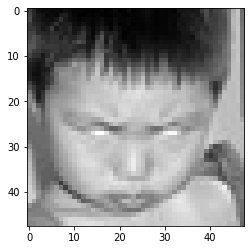

In [13]:
DATASET = "/content/drive/My Drive/AI on Spectrum - Web ML/Emotion Recognition/emotion-recognition/train"
CATEGORIES = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]

# Looping through the first loop to check each and every category
for category in CATEGORIES:
    path = os.path.join(DATASET, category)
    
    # Reading all the images from that category and storing the data in an image array
    for img in os.listdir(path):
        imagesArray = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
        plt.imshow(imagesArray, cmap="gray")
        plt.show()
        break
    break

In [14]:
print("Size of an Image placed in an Array:", imagesArray.shape)

Size of an Image placed in an Array: (48, 48)


# DATA FORMATION

the images were converted into Gray Scale, such that the images would no longer be used on the RGB Channels, by using `cv2.IMREAD_GRAYSCALE`. The grey-scale images were then resized into a fixed size of 48x48 dimension, so that the models should be working smoothly on the same sized of the scaled images. Once the scaling and conversion of channels was performed the images were stored into an array by appending the images data with the categories. However, this was an essential step in order for me to segregate these images into two separate arrays, each for features and labels

In [15]:
dataArray = []

def CreateDataArray():
  for category in CATEGORIES:
    path = os.path.join(DATASET, category)
    classIndex = CATEGORIES.index(category)
    
    for img in os.listdir(path):
      try:
        imagesArray = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
        resizedImagesArray = cv2.resize(imagesArray, (SIZE_OF_IMAGE, SIZE_OF_IMAGE))
        dataArray.append([resizedImagesArray, classIndex])
      except Exception as e:
        pass

CreateDataArray()

print("Length of the Data Array:", len(dataArray))

Length of the Data Array: 28709


In [16]:
# Randomly shuffling the data in the data array before segregating into features and labels
random.shuffle(dataArray)

# Features and Label array    
featuresArray = []
labelArray = []

# Appending features and label array from the data array
for features, label in dataArray:
  featuresArray.append(features)
  labelArray.append(label)

# Once the looping through has been done, the images are reshaped and stored using numpy array   
featuresArray = np.array(featuresArray).reshape(-1, SIZE_OF_IMAGE, SIZE_OF_IMAGE, 1)
labelArray = np.array(labelArray)

uniqueLabelList = []

# To find out the list of unique number of labels present in the label array
def unique(list): 
    for x in list: 
        # check if exists in uniqueLabelList or not 
        if x not in uniqueLabelList: 
            uniqueLabelList.append(x) 
    
unique(labelArray)

print("Length (Number) of the Features Array:", len(featuresArray))
print("Number of Unique Labels:", len(uniqueLabelList))

Length (Number) of the Features Array: 28709
Number of Unique Labels: 7


# Data/Image Exploration and Augmentation

I had performed the image augmentation by using the cv2 functions for basic edge detection using Laplacian and by also comparing between the unnormalized images histogram with normalized images histogram. These necessary portions of augmentation were indeed needed to ensure that the scaled images are accurate enough before being used for the classification task.

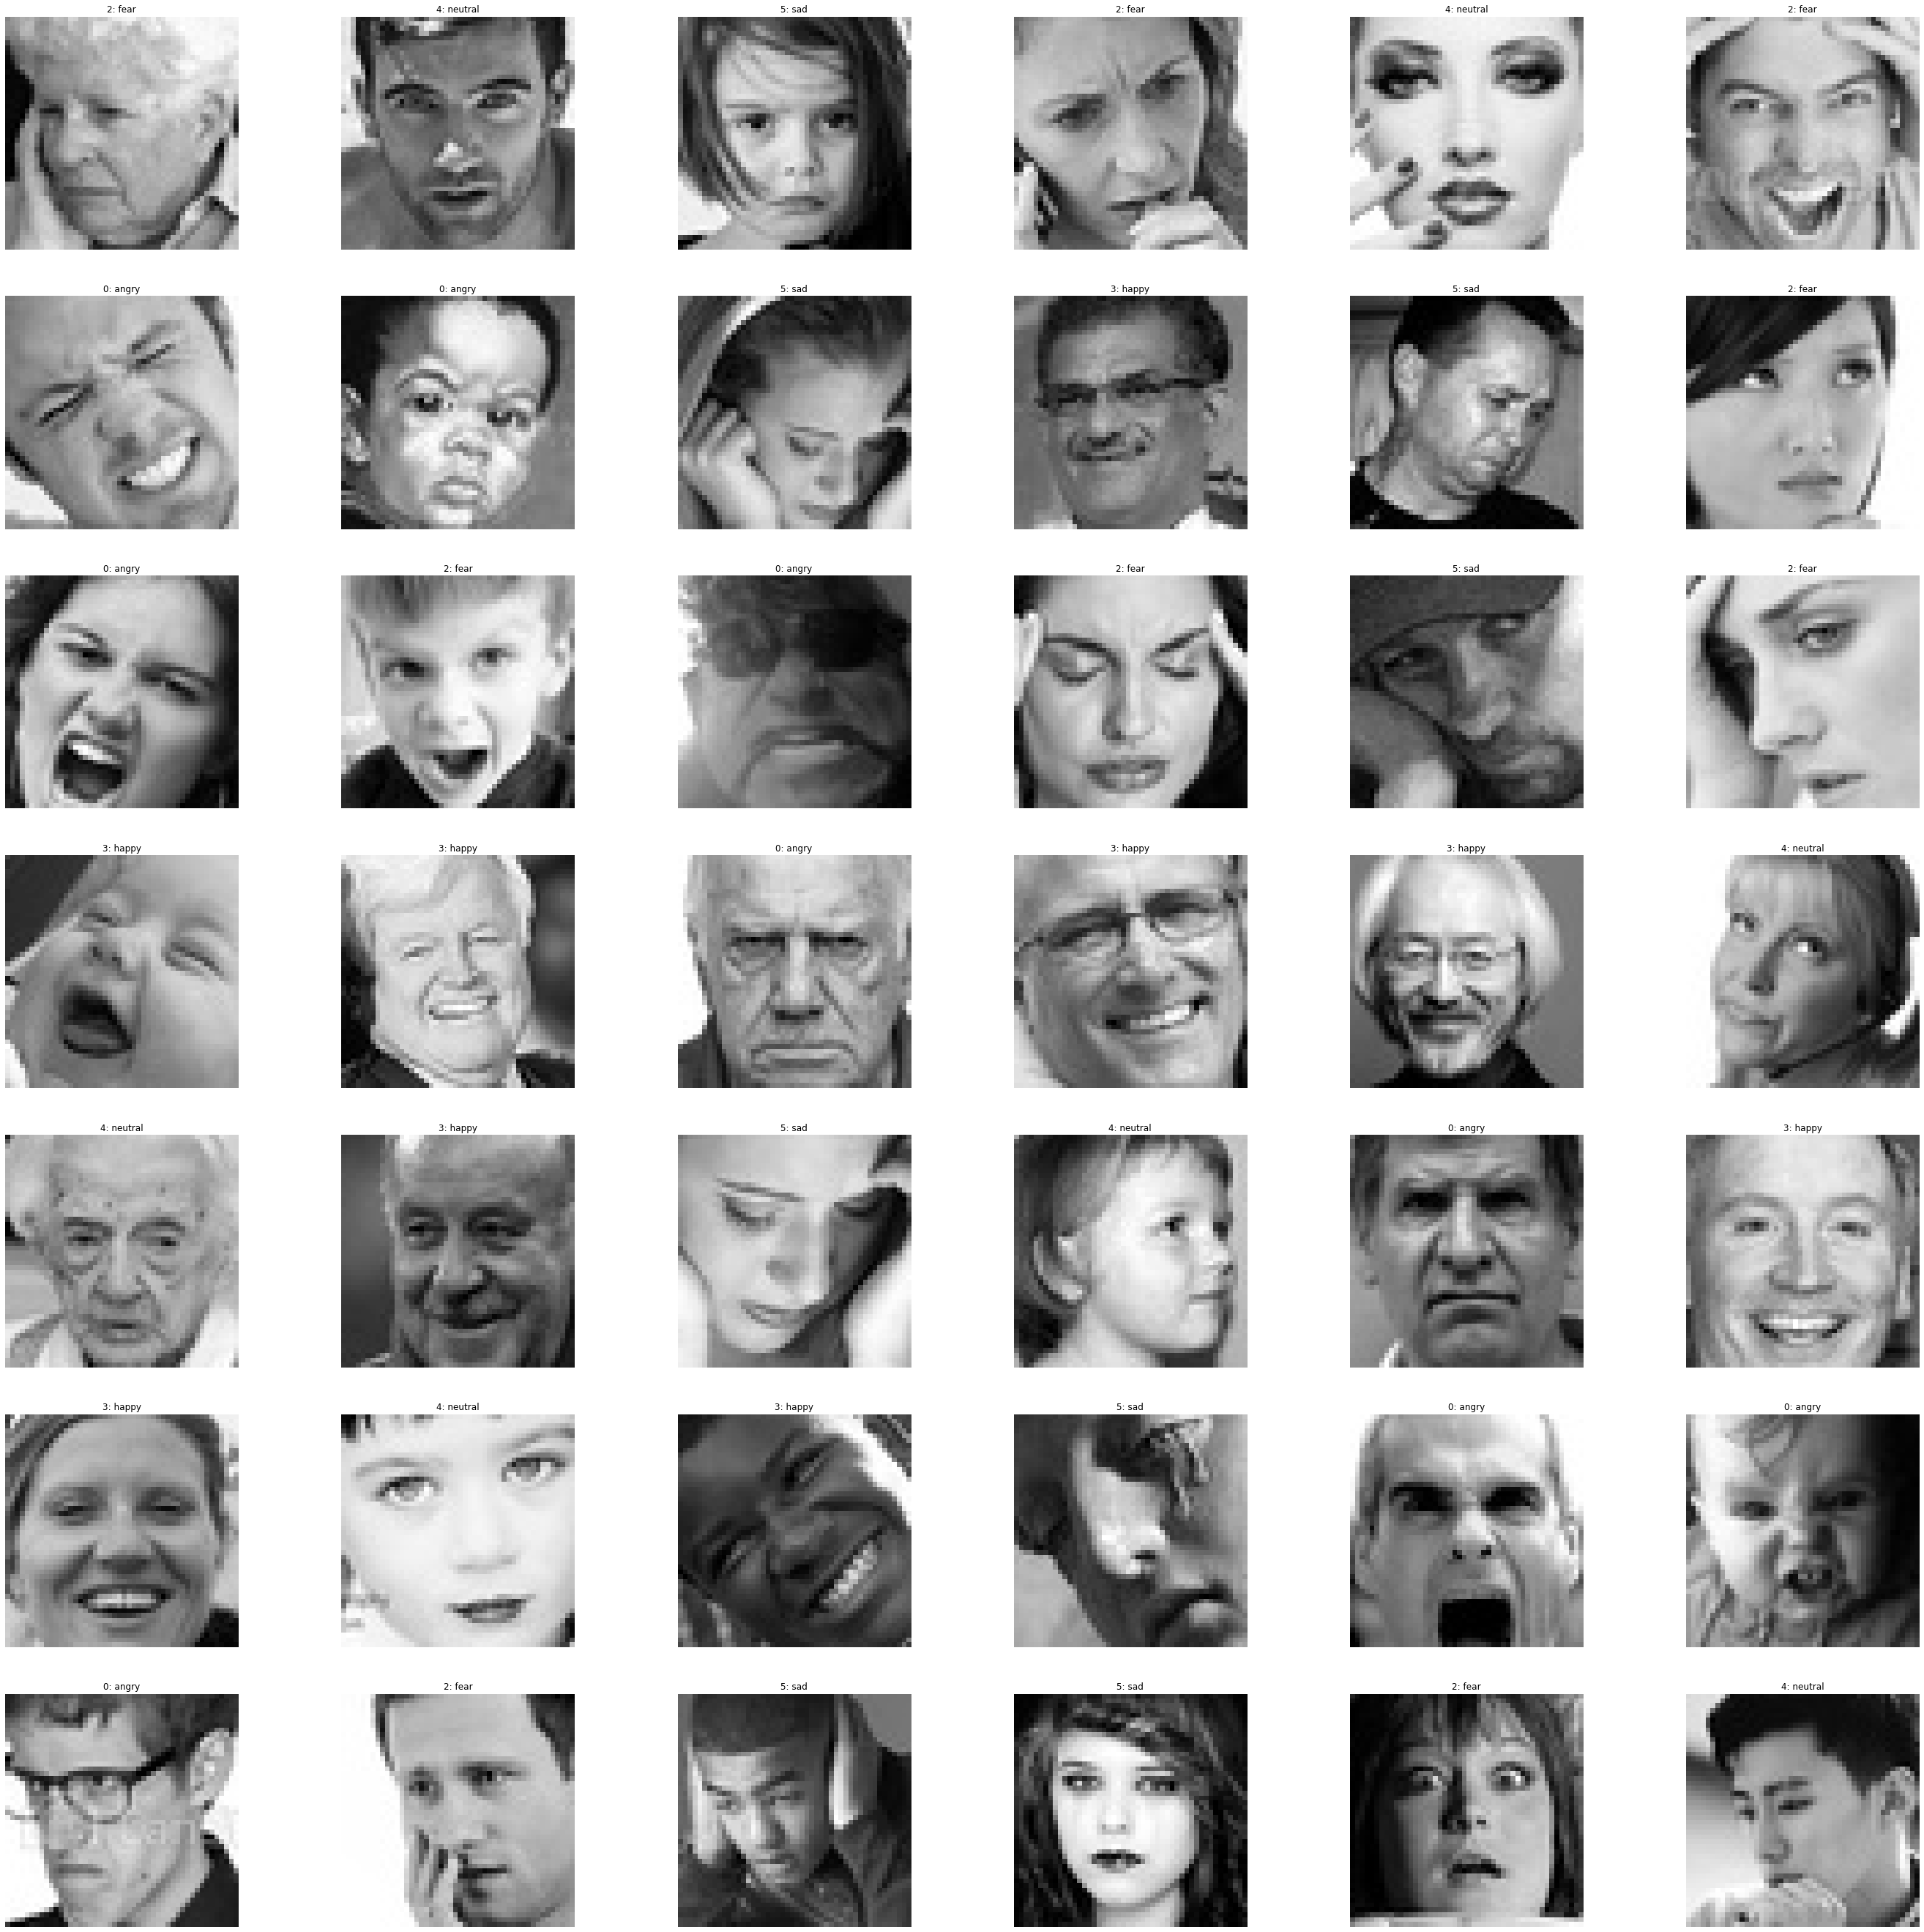

In [17]:
rowImages, colImages = [7, 6]
fig, axes = plt.subplots(rowImages, colImages, figsize=(SIZE_OF_IMAGE, SIZE_OF_IMAGE))
axes = axes.ravel()

# Looping through the features array to plot the images
for i in range(rowImages * colImages):
    featuresArrayLength = np.squeeze(featuresArray)
    index = random.randint(0, len(featuresArrayLength))
    image = featuresArrayLength[index]
    axes[i].imshow(image, cmap="gray")
    axes[i].set_title(str(labelArray[index]) + ': ' + CATEGORIES[labelArray[index]])
    axes[i].axis('off')

The task of Laplacian image augmentation was used to check the linearity between the pixels of the image, such that the non-linear pixels ranging from white to grey and then to black, were then could be removed in the process of normalization

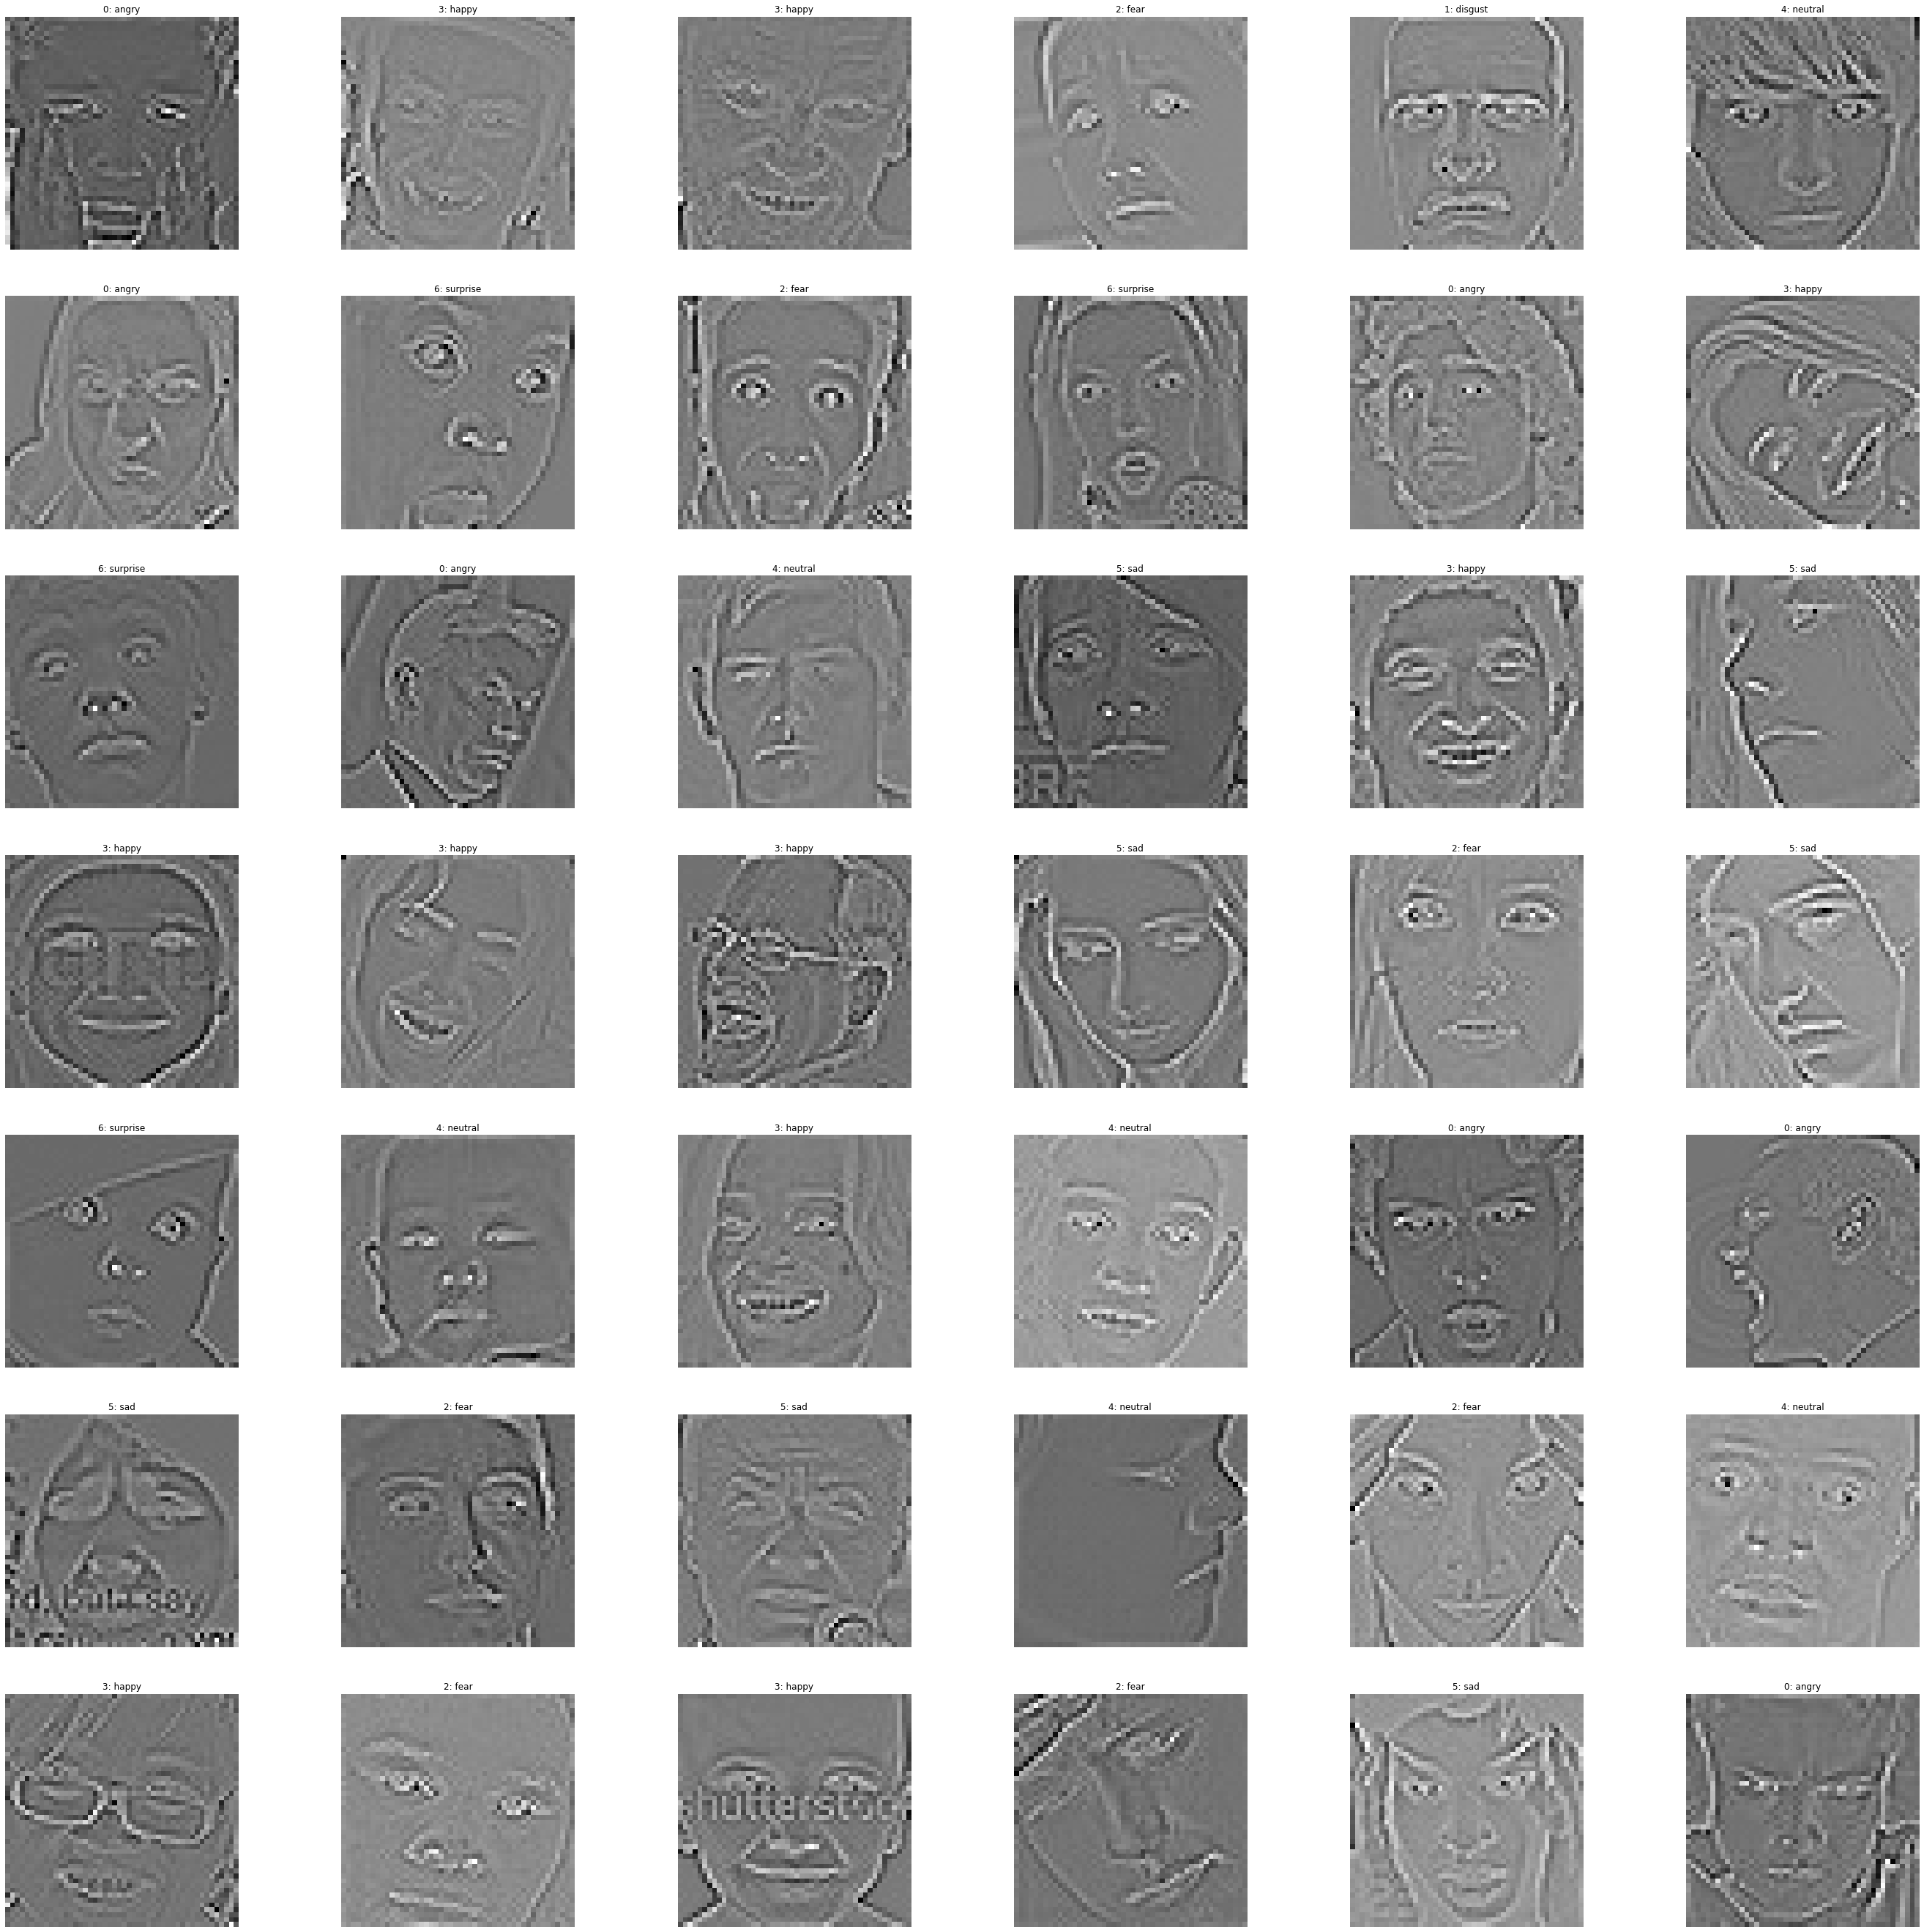

In [18]:
rowImages, colImages = [7, 6]
fig, axes = plt.subplots(rowImages, colImages, figsize=(SIZE_OF_IMAGE, SIZE_OF_IMAGE))
axes = axes.ravel()

# Looping through the features array to plot the laplacian images
for i in range(rowImages * colImages):
    featuresArrayLength = np.squeeze(featuresArray)
    index = random.randint(0, len(featuresArrayLength))
    image = featuresArrayLength[index]
    laplacian = cv2.Laplacian(image, cv2.CV_64F)  
    axes[i].imshow(laplacian, cmap="gray")
    axes[i].set_title(str(labelArray[index]) + ': ' + CATEGORIES[labelArray[index]])
    axes[i].axis('off')

The images were then used to check for the skewness of the image pixel values. By looking at the histogram this gives an idea that the linearity progression between the pixels are now broken and this could now lead to be used ahead for train and test splits

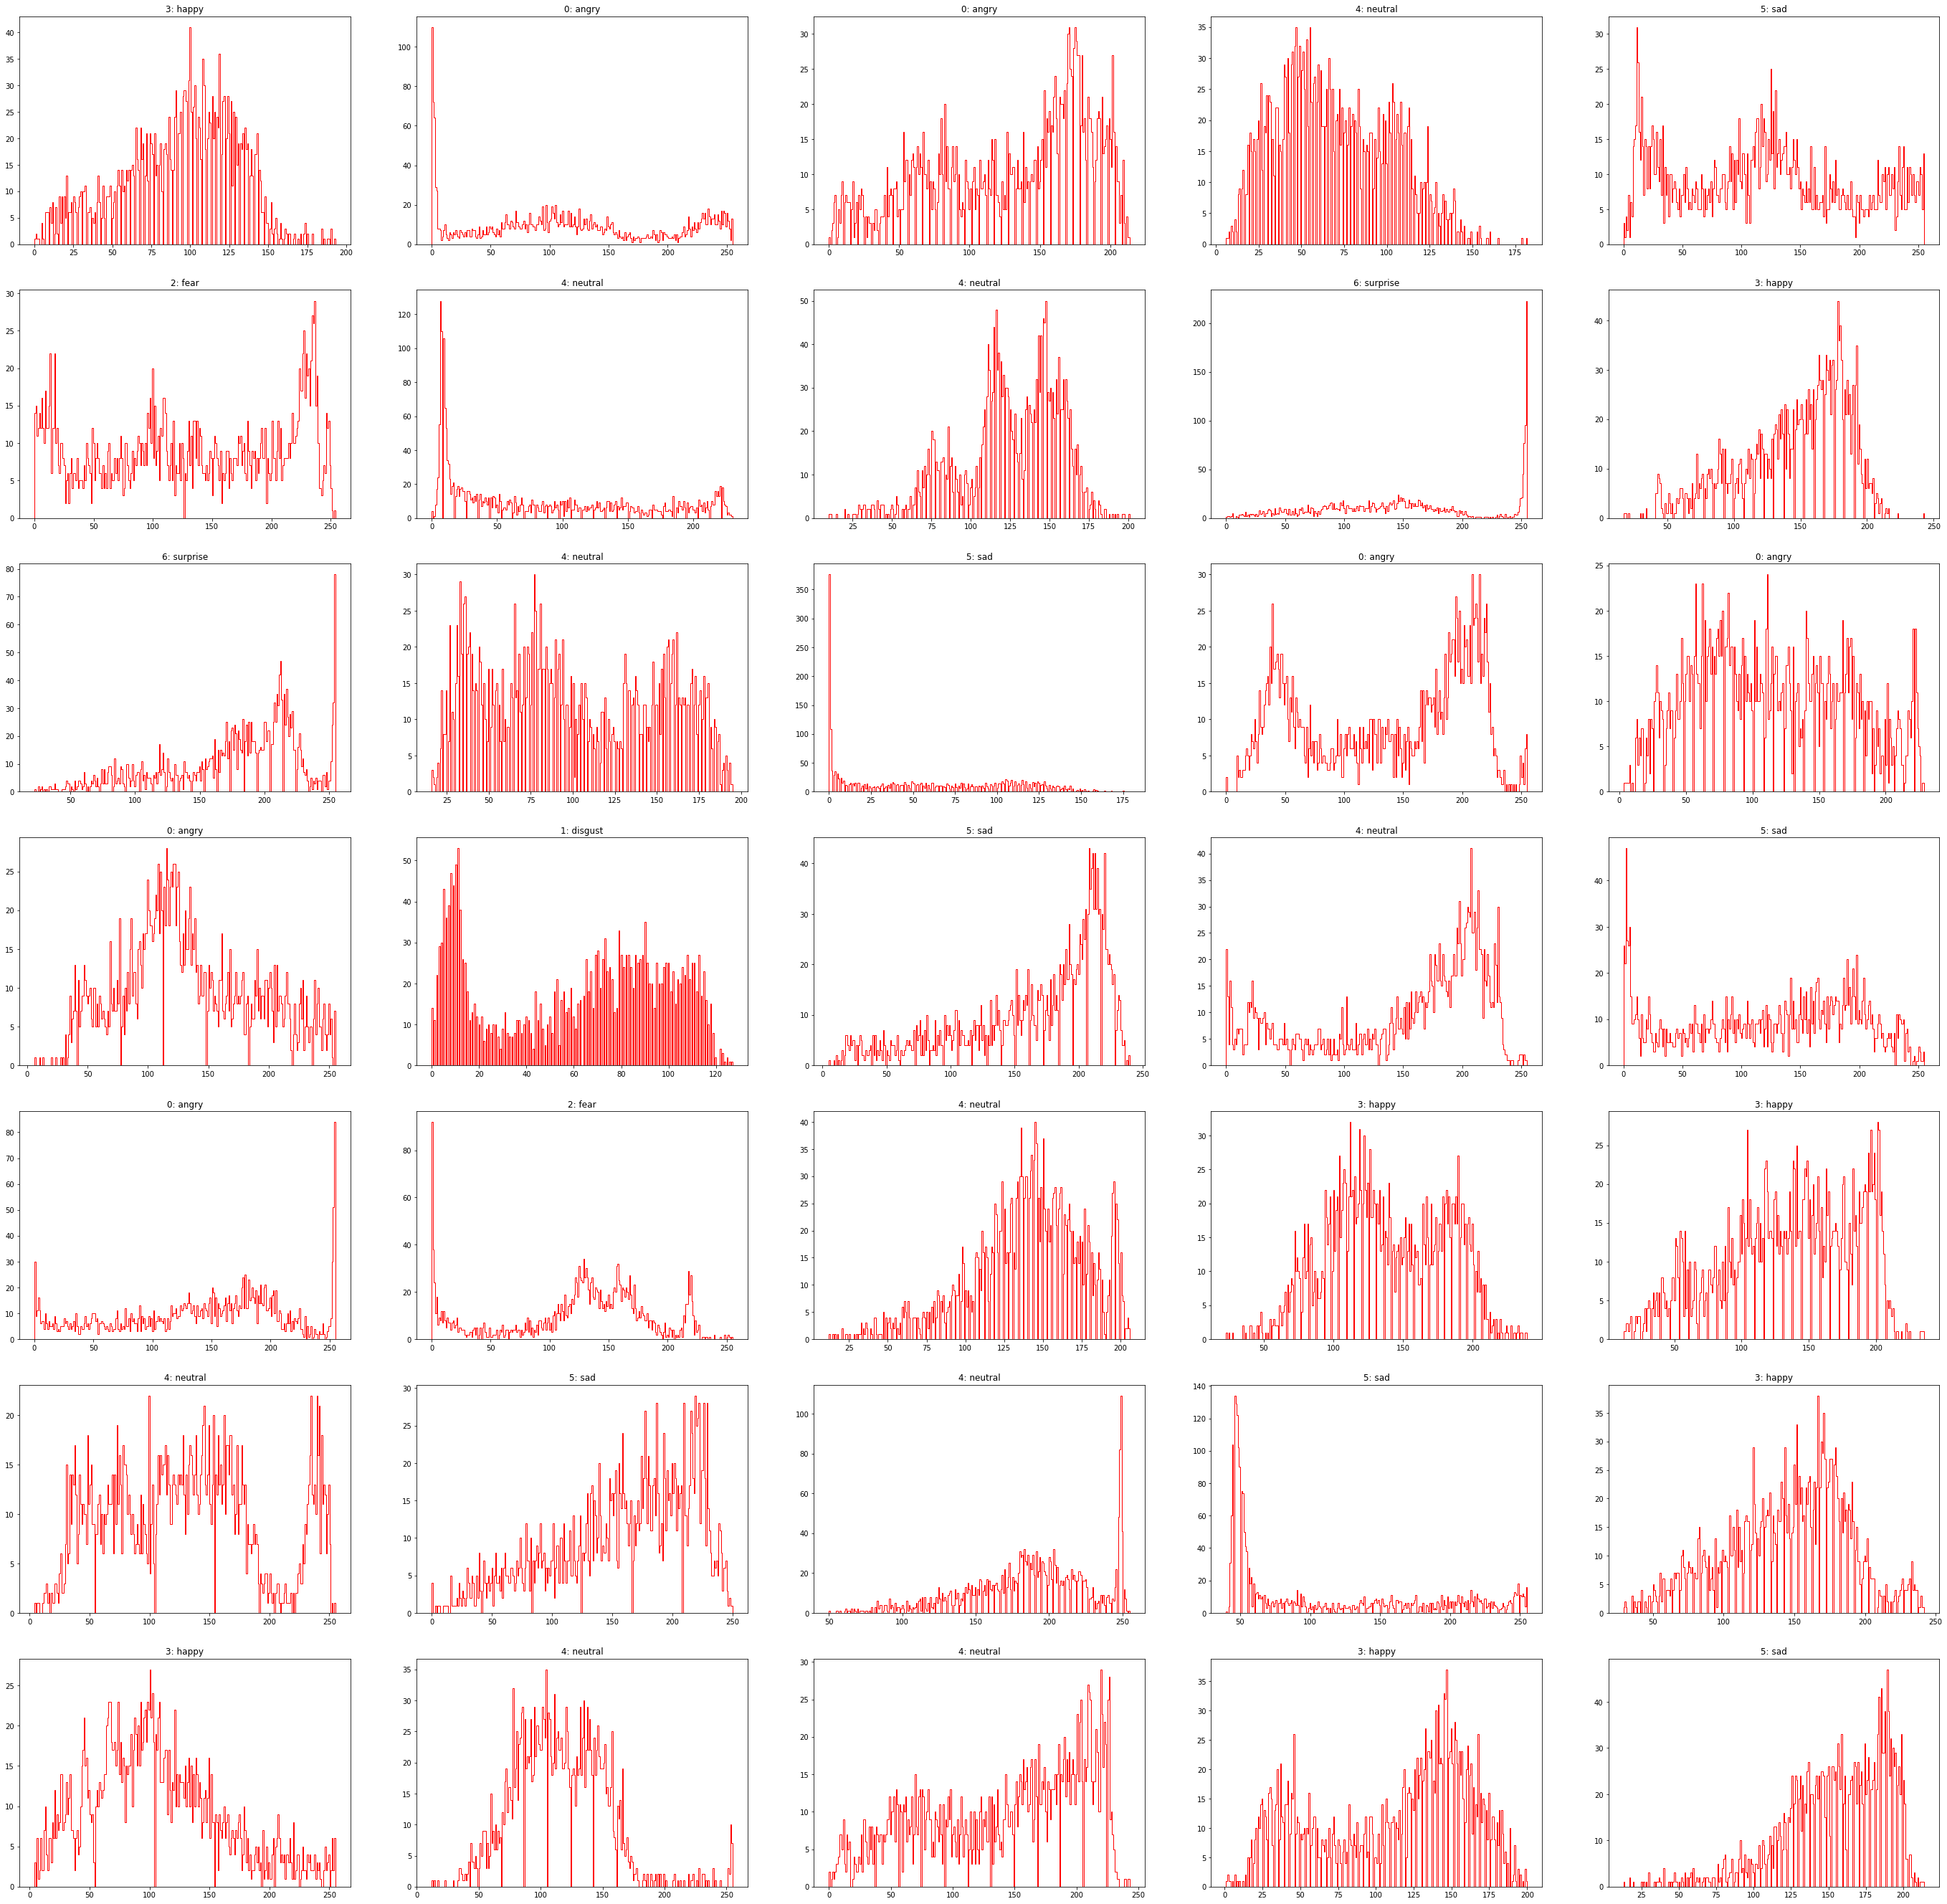

In [19]:
rowImages, colImages = [7, 5]
fig, axes = plt.subplots(rowImages, colImages, figsize=(SIZE_OF_IMAGE, SIZE_OF_IMAGE))
axes = axes.ravel()

# Looping through the features array to plot the Histogram of the unnormalized images
for i in range(rowImages * colImages):
    featuresArrayLength = np.squeeze(featuresArray)
    index = random.randint(0, len(featuresArrayLength))
    image = featuresArrayLength[index]
    axes[i].hist(image.ravel(), bins=256, histtype="step", color="red")
    axes[i].set_title(str(labelArray[index]) + ': ' + CATEGORIES[labelArray[index]]) 

# Image Normalization

This is now to normalize the image and viewing the images histogram to compare and contrast with the histogram of the unnormlized image

In [20]:
# Normalizing the Features Arrays first
featuresArray = featuresArray/255.0

I have performed the histogram evaluation on the Laplace images by first keeping the features array unnormalized and visualising the data for any skewness, and then performed the normalization over the features array, as to notice the difference between the pixel linearity

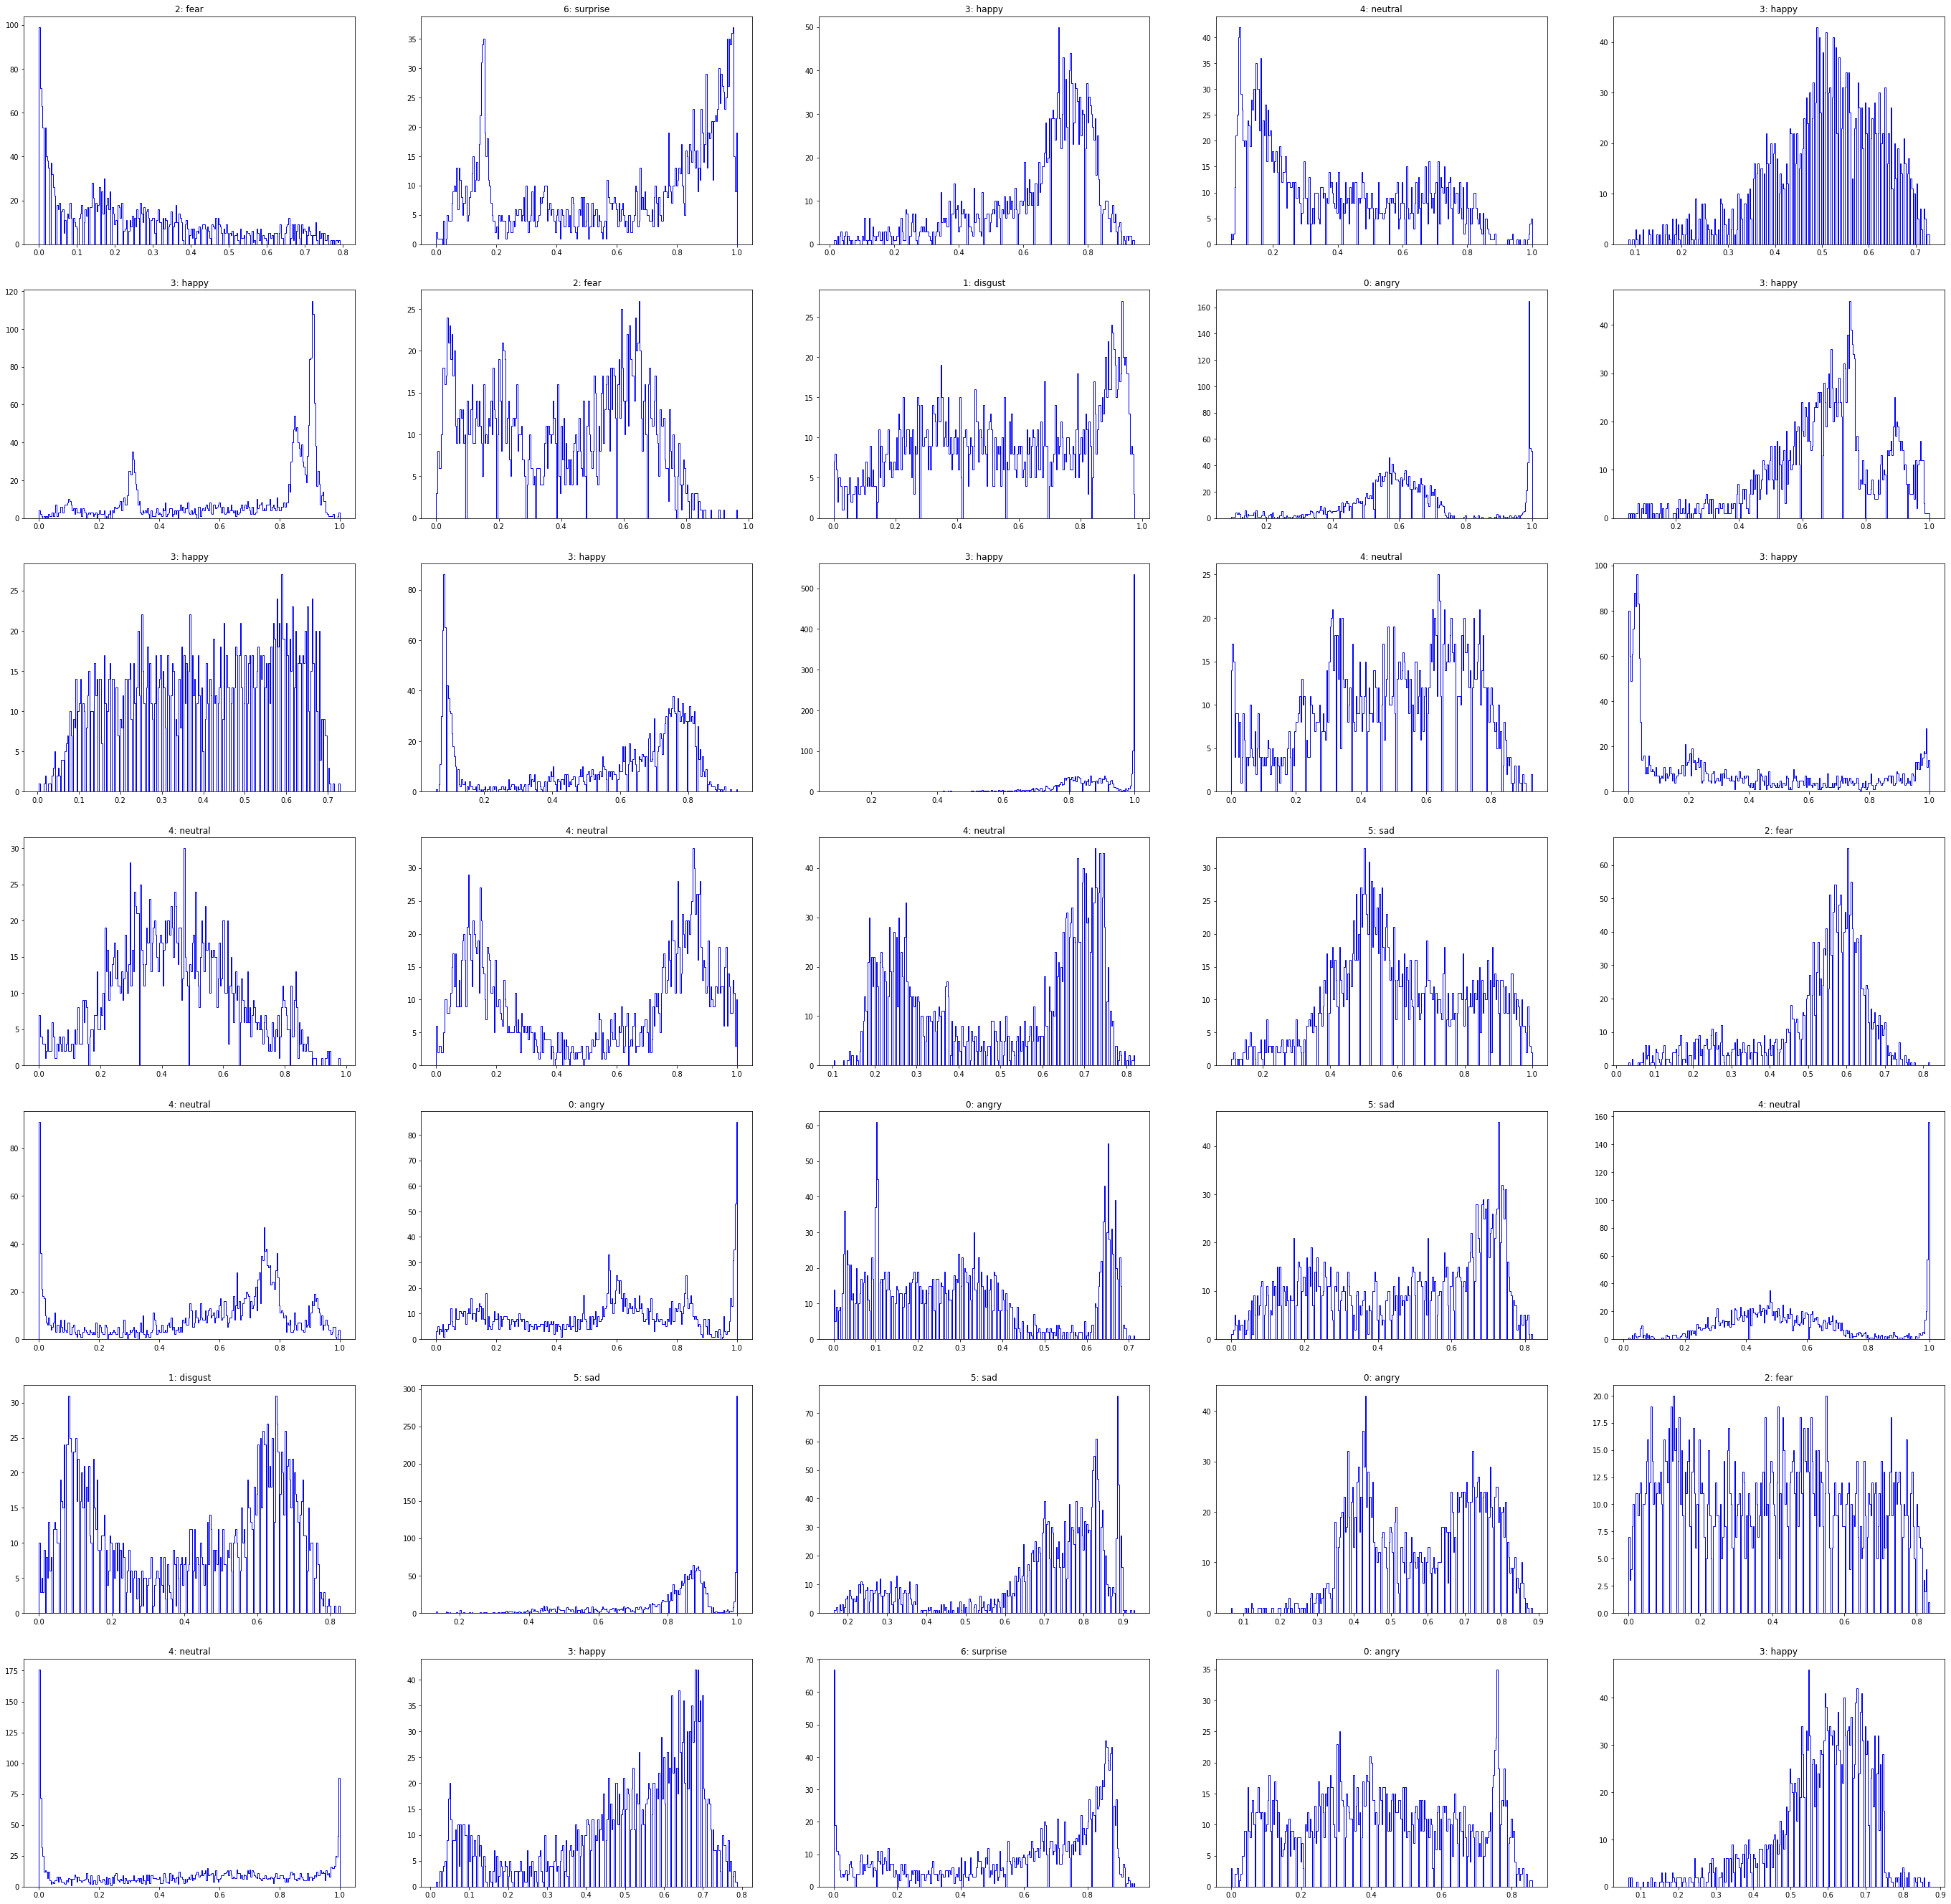

In [21]:
rowImages, colImages = [7, 5]
fig, axes = plt.subplots(rowImages, colImages, figsize=(SIZE_OF_IMAGE, SIZE_OF_IMAGE))
axes = axes.ravel()

# Looping through the features array to plot the Histogram of the normalized images
for i in range(rowImages * colImages):
    featuresArrayLength = np.squeeze(featuresArray)
    index = random.randint(0, len(featuresArrayLength))
    image = featuresArrayLength[index]
    axes[i].hist(image.ravel(), bins=256, histtype="step", color="blue")
    axes[i].set_title(str(labelArray[index]) + ': ' + CATEGORIES[labelArray[index]]) 

# Train Test Split

The normalized features array and label array was here used to perform the splitting. The splitting was done as 80% training images and 20% test images using the test_size = 0.2 and random_seed = 42 to perform the shuffling. However, I had also performed the randomized shuffling before the augmentation and normalization had taken place using the random library of python and shuffle() to unknowingly shuffle the features array

## Without Augmentation

In [22]:
print("Shapes of Features and Label Array: ", featuresArray.shape, labelArray.shape)
#Splitting training and testing dataset
featuresTrainX, featuresTestX, labelTrainY, labelTestY = train_test_split(featuresArray, labelArray, test_size=0.2, random_state=42)

print("Shapes of featuresTrainX and labelTrainY: ", featuresTrainX.shape, labelTrainY.shape)
print("Shapes of featuresTestX and labelTestY: ", featuresTestX.shape, labelTestY.shape)

histLabelTrainY = labelTrainY
histLabelTestY = labelTestY
categoryCount = len(set(labelTrainY))

#Converting the labels into one hot encoding
labelTrainY = to_categorical(labelTrainY, 7)
labelTestY = to_categorical(labelTestY, 7)

Shapes of Features and Label Array:  (28709, 48, 48, 1) (28709,)
Shapes of featuresTrainX and labelTrainY:  (22967, 48, 48, 1) (22967,)
Shapes of featuresTestX and labelTestY:  (5742, 48, 48, 1) (5742,)


## With Augmentation

In [23]:
train_ratio = 0.70
validation_ratio = 0.10
test_ratio = 0.20
# train is now 75% of the entire data set
# the _junk suffix means that we drop that variable completely
x_train, x_test, y_train, y_test = train_test_split(featuresArray, labelArray, test_size = 1 - train_ratio)
# test is now 10% of the initial data set
# validation is now 15% of the initial data set
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio)) 

print("Shapes of featuresTrainX and labelTrainY: ", x_train.shape, y_train.shape)
print("Shapes of featuresTestX and labelTestY: ", x_test.shape, y_test.shape)
print("Shapes of ValidationX and ValidationY: ", x_val.shape, y_val.shape)

histLabelTrainY = y_train
histLabelTestY = y_test
histLabelValY = y_val
categoryCount = len(set(y_train))

#Converting the labels into one hot encoding
y_train = to_categorical(y_train, 7)
y_test = to_categorical(y_test, 7)
y_val = to_categorical(y_val, 7)

Shapes of featuresTrainX and labelTrainY:  (20096, 48, 48, 1) (20096,)
Shapes of featuresTestX and labelTestY:  (5742, 48, 48, 1) (5742,)
Shapes of ValidationX and ValidationY:  (2871, 48, 48, 1) (2871,)


# Train set and Test set Exploration

From the histogram, the frequency of labels in each of the classes/categories were visualized. However, the train and test splits were visualised using different colour labels to get an overview of the split

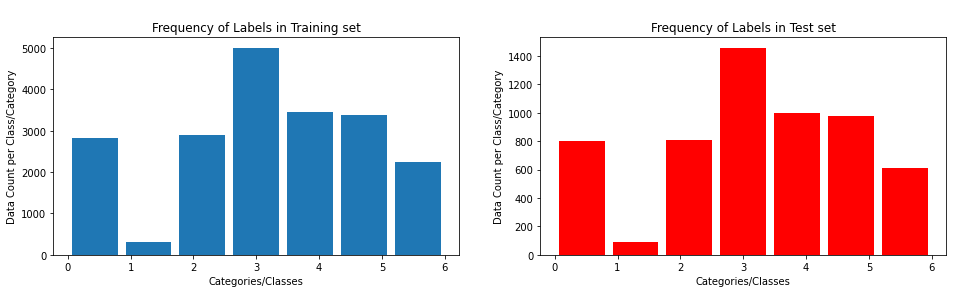

In [24]:
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.hist(histLabelTrainY, bins=categoryCount, rwidth=0.85)
plt.title('\nFrequency of Labels in Training set')
plt.xlabel('Categories/Classes')
plt.ylabel('Data Count per Class/Category')

plt.subplot(1,2,2)
plt.hist(histLabelTestY, bins=categoryCount, color="red", rwidth=0.85)
plt.title('\nFrequency of Labels in Test set')
plt.xlabel('Categories/Classes')
plt.ylabel('Data Count per Class/Category')
plt.show()

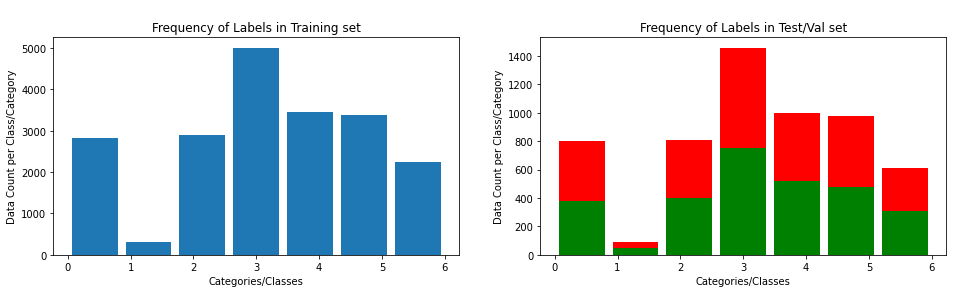

In [25]:
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.hist(histLabelTrainY, bins=categoryCount, rwidth=0.85)
plt.title('\nFrequency of Labels in Training set')
plt.xlabel('Categories/Classes')
plt.ylabel('Data Count per Class/Category')

plt.subplot(1,2,2)
plt.hist(histLabelTestY, bins=categoryCount, color="red", rwidth=0.85)
plt.title('\nFrequency of Labels in Test set')
plt.xlabel('Categories/Classes')
plt.ylabel('Data Count per Class/Category')

# plt.subplot(1,1,1)
plt.hist(histLabelValY, bins=categoryCount, color="green", rwidth=0.85)
plt.title('\nFrequency of Labels in Test/Val set')
plt.xlabel('Categories/Classes')
plt.ylabel('Data Count per Class/Category')
plt.show()

# Emotion CNN Classifier Model

There were three different convolutional layers used, each of them had their own activation function “ReLu” (Rectified Linear Units) which was used to break the linearity progression by removing the negative pixel values from the images array while performing the convolution step. The filter size for the first convolution layer was 32, and the kernel size was 5x5, which maps the input images to the grid of 5x5, eliminating the non-essential feature pixels

In [30]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras import regularizers, optimizers

#Building the model
emotionsClassifier = Sequential()

emotionsClassifier.add(Conv2D(filters=32, kernel_size=(5,5), input_shape=featuresTrainX.shape[1:], kernel_regularizer=regularizers.l2(0.001)))
emotionsClassifier.add(Activation('relu'))
emotionsClassifier.add(BatchNormalization())
emotionsClassifier.add(MaxPooling2D(pool_size=(2, 2)))
emotionsClassifier.add(Dropout(0.25))

emotionsClassifier.add(Conv2D(filters=64, kernel_size=(3, 3), kernel_regularizer=regularizers.l2(0.001)))
emotionsClassifier.add(Activation('relu'))
emotionsClassifier.add(BatchNormalization())
emotionsClassifier.add(MaxPooling2D(pool_size = (2, 2)))
emotionsClassifier.add(Dropout(0.25))

emotionsClassifier.add(Conv2D(filters=128, kernel_size=(3, 3), kernel_regularizer=regularizers.l2(0.001)))
emotionsClassifier.add(Activation('relu'))
emotionsClassifier.add(BatchNormalization())
emotionsClassifier.add(MaxPooling2D(pool_size=(2, 2)))
emotionsClassifier.add(Dropout(0.25))

emotionsClassifier.add(Flatten())

emotionsClassifier.add(Dense(256))
emotionsClassifier.add(Activation('relu'))
emotionsClassifier.add(BatchNormalization())
emotionsClassifier.add(Dropout(0.5))

emotionsClassifier.add(Dense(128))
emotionsClassifier.add(Activation('relu'))
emotionsClassifier.add(BatchNormalization())
emotionsClassifier.add(Dropout(0.5))

emotionsClassifier.add(Dense(7))
emotionsClassifier.add(Activation('softmax'))

emotionsClassifier.compile(loss='categorical_crossentropy', 
                        optimizer='adam', 
                        metrics=['categorical_accuracy'])

emotionsClassifier.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 44, 44, 32)        832       
_________________________________________________________________
activation_6 (Activation)    (None, 44, 44, 32)        0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 44, 44, 32)        128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 22, 22, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 20, 20, 64)        18496     
_________________________________________________________________
activation_7 (Activation)    (None, 20, 20, 64)       

This training data was further used to perform the splitting between the train and validation split using the validation_split parameter of the .fit(). The split was of 10% i.e. 0.1 consisted of 2663 train samples, and 296 validation samples

In [31]:
trainedEmotionsClassiferModel = emotionsClassifier.fit(featuresTrainX, 
                                                 labelTrainY, 
                                                 batch_size=BATCH_SIZE, 
                                                 epochs=512, 
                                                 validation_split=0.1)

Epoch 1/512
646/646 [==============================] - 8s 12ms/step - loss: 2.3039 - categorical_accuracy: 0.2419 - val_loss: 1.7840 - val_categorical_accuracy: 0.3461
Epoch 2/512
646/646 [==============================] - 7s 11ms/step - loss: 1.8010 - categorical_accuracy: 0.3476 - val_loss: 1.6903 - val_categorical_accuracy: 0.3783
Epoch 3/512
646/646 [==============================] - 7s 11ms/step - loss: 1.6629 - categorical_accuracy: 0.3938 - val_loss: 1.6105 - val_categorical_accuracy: 0.4149
Epoch 4/512
646/646 [==============================] - 7s 11ms/step - loss: 1.5978 - categorical_accuracy: 0.4201 - val_loss: 1.7024 - val_categorical_accuracy: 0.3879
Epoch 5/512
646/646 [==============================] - 7s 11ms/step - loss: 1.5400 - categorical_accuracy: 0.4456 - val_loss: 1.6345 - val_categorical_accuracy: 0.4088
Epoch 6/512
646/646 [==============================] - 7s 11ms/step - loss: 1.4872 - categorical_accuracy: 0.4687 - val_loss: 1.4384 - val_categorical_accuracy:

In [ ]:
# from keras.preprocessing.image import ImageDataGenerator

# # Data Augmentation.
# train_datagen = ImageDataGenerator(
#     rotation_range=15,
#     width_shift_range=0.15,
#     height_shift_range=0.15,
#     shear_range=0.15,
#     zoom_range=0.15,
#     horizontal_flip=True,
# )
# train_datagen.fit(x_train)

In [ ]:
# from keras.preprocessing.image import ImageDataGenerator

# train_datagen = ImageDataGenerator(rescale=1./255,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     validation_split=0.1) # set validation split

# train_generator = train_datagen.flow(
#     featuresTrainX,
#     labelTrainY, 
#     batch_size=BATCH_SIZE,
#     subset='training') # set as training data

# validation_generator = train_datagen.flow(
#     featuresTrainX,
#     labelTrainY, # same directory as training data
#     batch_size=BATCH_SIZE,
#     subset='validation') # set as validation data

In [ ]:
# import pathlib
# import shutil
# import tempfile
# import tensorflow as tf

# from  IPython import display
# from matplotlib import pyplot as plt
# from sklearn.metrics import roc_auc_score

# logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
# shutil.rmtree(logdir, ignore_errors=True)

# # Load the TensorBoard notebook extension
# %load_ext tensorboard

# # Open an embedded TensorBoard viewer
# %tensorboard --logdir {logdir}/models

# Visualisation of the Model's Accuracy and Model's Loss

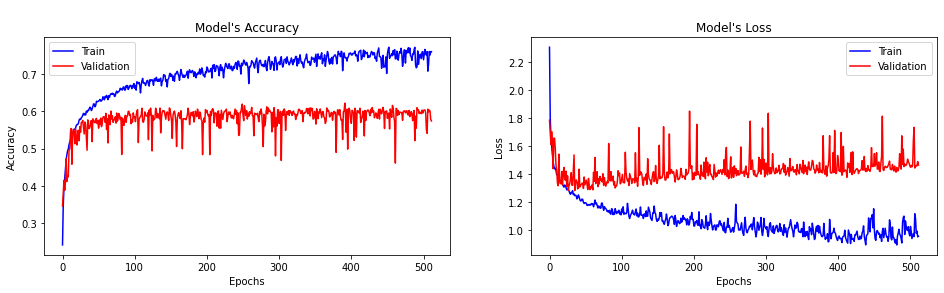

In [32]:
#plotting graphs for accuracy 
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.plot(trainedEmotionsClassiferModel.history['categorical_accuracy'], 'b-')
plt.plot(trainedEmotionsClassiferModel.history['val_categorical_accuracy'], 'r-')
plt.title("\nModel's Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

plt.subplot(1,2,2)
plt.plot(trainedEmotionsClassiferModel.history['loss'], 'b-')
plt.plot(trainedEmotionsClassiferModel.history['val_loss'], 'r-')
plt.title("\nModel's Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()

To save the Model in order to perform the Independent Evaluation

In [ ]:
#emotionsClassifier.save("emotionsClassifierModel.h5")

# Prediction

I had used different performance metrics for evaluation, such as Accuracy, Precision, Recall, F1 Score and ROC AUC Score. These metrics were used to determine the true positive, false positive, true negative and false negative values for the predictions when compared with the labelTestY. All these performance metrics showcased that the Models are performing highly accurate

In [33]:
# model = tf.keras.models.load_model("emotionsClassifierModel.h5")

predictions = emotionsClassifier.predict_classes(featuresTestX)

predicted = to_categorical(predictions, 7)

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(labelTestY, predicted)

# precision tp / (tp + fp)
precision = precision_score(labelTestY, predicted, average="weighted")

# recall: tp / (tp + fn)
recall = recall_score(labelTestY, predicted, average="weighted")

# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(labelTestY, predicted, average="weighted")

# ROC AUC
auc = roc_auc_score(labelTestY, predicted, average="weighted")

print("\nPrediction Test Accuracy: %f" % accuracy)
print('Precision: %f' % precision)
print('Recall: %f' % recall)
print('F1 score: %f' % f1)
print('ROC AUC: %f\n' % auc)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).

Prediction Test Accuracy: 0.584639
Precision: 0.591437
Recall: 0.584639
F1 score: 0.583088
ROC AUC: 0.751458



# Visualizing the Prediciton

This is to check that for the given unseen test data, how many number of classes are predicied correctly and incorrectly


Found '3357' Labels which are Predicted Correctly



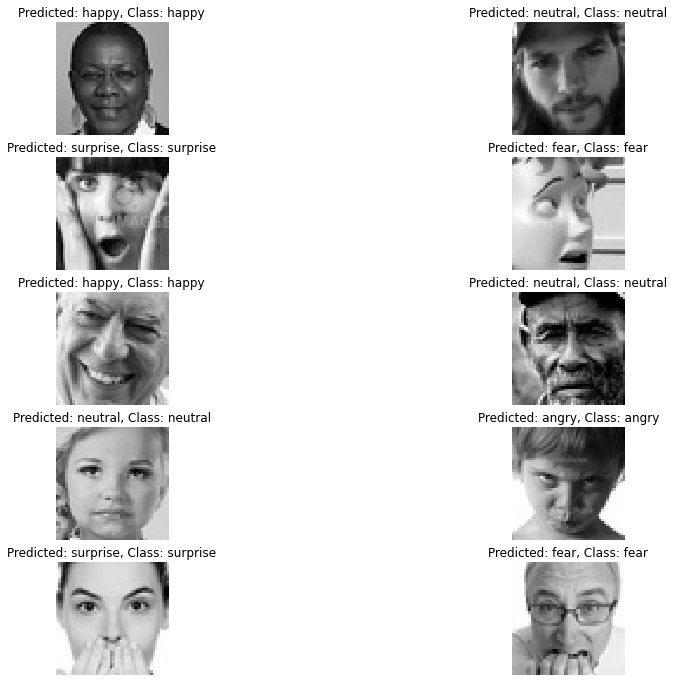

In [34]:
multilabelPrediction = np.argmax(np.round(predicted), axis=1)
multilabelTestY = np.argmax(np.round(labelTestY), axis=1)

correct = np.where(multilabelPrediction == multilabelTestY)[0]
print("\nFound '%d' Labels which are Predicted Correctly\n" % len(correct))

plt.figure(figsize=(15,12))
for i, correct in enumerate(correct[:10]):
    plt.subplot(5, 2, i+1)
    plt.imshow(featuresTestX[correct].reshape(48,48), cmap='gray', interpolation='none')
    plt.title("Predicted: {}, Class: {}".format(CATEGORIES[multilabelTestY[correct]], CATEGORIES[multilabelPrediction[correct]]))
    plt.axis('off')


Found '2385' Labels which are Predicted Incorrectly



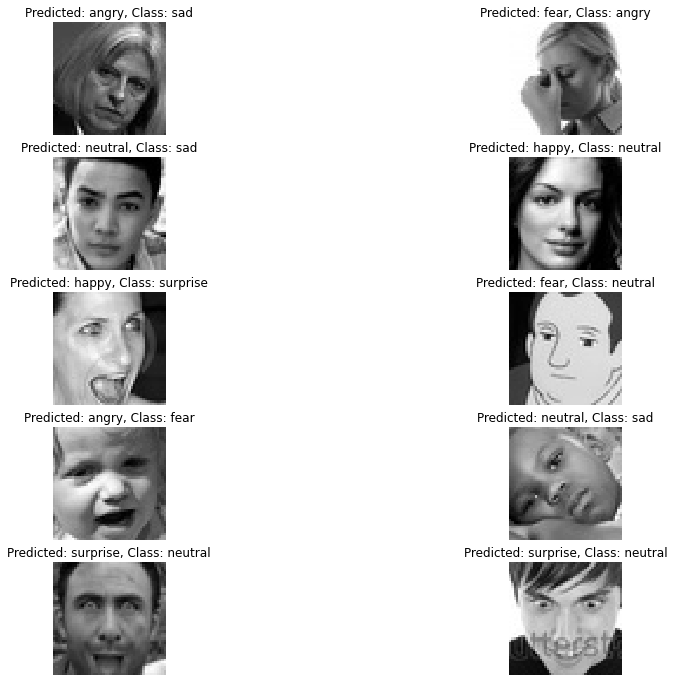

In [35]:
incorrect = np.where(multilabelPrediction != multilabelTestY)[0]
print("\nFound '%d' Labels which are Predicted Incorrectly\n" % len(incorrect))

plt.figure(figsize=(15,12))
for i, incorrect in enumerate(incorrect[:10]):
    plt.subplot(5, 2, i+1)
    plt.imshow(featuresTestX[incorrect].reshape(48,48), cmap='gray', interpolation='none')
    plt.title("Predicted: {}, Class: {}".format(CATEGORIES[multilabelTestY[incorrect]], CATEGORIES[multilabelPrediction[incorrect]]))
    plt.axis('off')

# Classification Report

had generated a classification report with Precision, Recall, F1 Score and Support for each of the classes individually using the Sklearn metrics which also provided the accuracy across all the unique categories label along with an average score

In [36]:
classification_metrics = classification_report(multilabelTestY, multilabelPrediction, target_names=CATEGORIES)
print(classification_metrics)

              precision    recall  f1-score   support

       angry       0.52      0.45      0.48       820
     disgust       0.65      0.42      0.51        85
        fear       0.48      0.36      0.41       828
       happy       0.81      0.75      0.78      1443
     neutral       0.54      0.53      0.53      1015
         sad       0.43      0.58      0.49       943
    surprise       0.65      0.80      0.72       608

    accuracy                           0.58      5742
   macro avg       0.58      0.56      0.56      5742
weighted avg       0.59      0.58      0.58      5742



Lastly, everything was summed up with a Confusion Matrix as to get a clear idea of which classes were incorrectly classified and what were the total count of those incorrectly predicted classes

In [37]:
cm = confusion_matrix(multilabelTestY, multilabelPrediction)

def plot_confusion_matrix(cm, CATEGORIES,
                          normalize=False,
                          title="Confusion Matrix",
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(15,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(CATEGORIES))
    plt.xticks(tick_marks, CATEGORIES, rotation=45)
    plt.yticks(tick_marks, CATEGORIES)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("\nNormalized confusion matrix\n")
    else:
        print("\nConfusion matrix, without normalization\n")

    print(cm)

    thres = cm.max()/2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], 
                 horizontalalignment = "center",
                 color="white" if cm[i, j] > thres else "black")
    
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')


Confusion matrix, without normalization

[[ 308    8   77  113  144  131   22]
 [  16   27    9    4    7   21    1]
 [  94    1  275  100  141  167  104]
 [  22    0   11 1191   79   75   24]
 [  52    0   42  124  611  146   13]
 [  83    1   76   88  202  469   14]
 [  14    0   43   56   39   20  477]]


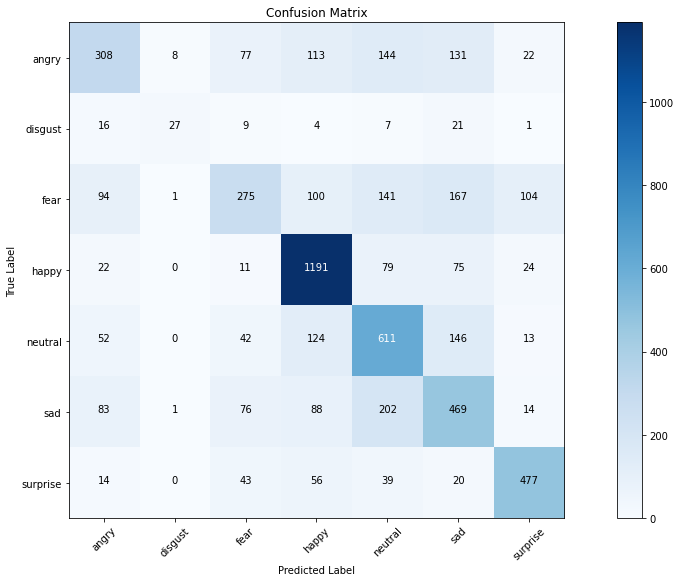

In [ ]:
plot_confusion_matrix(cm, CATEGORIES, title="Confusion Matrix")

In [38]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras import regularizers, optimizers

#Building the model
emotionsClassifier2 = Sequential()

emotionsClassifier2.add(Conv2D(filters=64, kernel_size=(5,5), input_shape=featuresTrainX.shape[1:], kernel_regularizer=regularizers.l2(0.001)))
emotionsClassifier2.add(Activation('relu'))
emotionsClassifier2.add(BatchNormalization())
emotionsClassifier2.add(MaxPooling2D(pool_size=(2, 2)))
emotionsClassifier2.add(Dropout(0.25))

emotionsClassifier2.add(Conv2D(filters=512, kernel_size=(3, 3), kernel_regularizer=regularizers.l2(0.001)))
emotionsClassifier2.add(Activation('relu'))
emotionsClassifier2.add(BatchNormalization())
emotionsClassifier2.add(MaxPooling2D(pool_size = (2, 2)))
emotionsClassifier2.add(Dropout(0.25))

emotionsClassifier2.add(Conv2D(filters=1024, kernel_size=(3, 3), kernel_regularizer=regularizers.l2(0.001)))
emotionsClassifier2.add(Activation('relu'))
emotionsClassifier2.add(BatchNormalization())
emotionsClassifier2.add(MaxPooling2D(pool_size=(2, 2)))
emotionsClassifier2.add(Dropout(0.25))

emotionsClassifier2.add(Flatten())

emotionsClassifier2.add(Dense(512))
emotionsClassifier2.add(Activation('relu'))
emotionsClassifier2.add(BatchNormalization())
emotionsClassifier2.add(Dropout(0.5))

emotionsClassifier2.add(Dense(256))
emotionsClassifier2.add(Activation('relu'))
emotionsClassifier2.add(BatchNormalization())
emotionsClassifier2.add(Dropout(0.5))

emotionsClassifier2.add(Dense(128))
emotionsClassifier2.add(Activation('relu'))
emotionsClassifier2.add(BatchNormalization())
emotionsClassifier2.add(Dropout(0.5))

emotionsClassifier2.add(Dense(7))
emotionsClassifier2.add(Activation('softmax'))

emotionsClassifier2.compile(loss='categorical_crossentropy', 
                        optimizer='adam', 
                        metrics=['categorical_accuracy'])

emotionsClassifier2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 44, 44, 64)        1664      
_________________________________________________________________
activation_12 (Activation)   (None, 44, 44, 64)        0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 44, 44, 64)        256       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 22, 22, 64)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 20, 20, 512)       295424    
_________________________________________________________________
activation_13 (Activation)   (None, 20, 20, 512)      

In [39]:
trainedEmotionsClassiferModel2 = emotionsClassifier2.fit(featuresTrainX, 
                                                 labelTrainY, 
                                                 batch_size=BATCH_SIZE, 
                                                 epochs=150, 
                                                 validation_split=0.1)

Epoch 1/150
646/646 [==============================] - 34s 53ms/step - loss: 2.8657 - categorical_accuracy: 0.2245 - val_loss: 2.2021 - val_categorical_accuracy: 0.2973
Epoch 2/150
646/646 [==============================] - 33s 52ms/step - loss: 2.0613 - categorical_accuracy: 0.3351 - val_loss: 1.8921 - val_categorical_accuracy: 0.3418
Epoch 3/150
646/646 [==============================] - 33s 52ms/step - loss: 1.8384 - categorical_accuracy: 0.3919 - val_loss: 1.9839 - val_categorical_accuracy: 0.3326
Epoch 4/150
646/646 [==============================] - 33s 52ms/step - loss: 1.9646 - categorical_accuracy: 0.4111 - val_loss: 2.0403 - val_categorical_accuracy: 0.3365
Epoch 5/150
646/646 [==============================] - 33s 52ms/step - loss: 1.9182 - categorical_accuracy: 0.4278 - val_loss: 2.3947 - val_categorical_accuracy: 0.2899
Epoch 6/150
646/646 [==============================] - 33s 52ms/step - loss: 1.9765 - categorical_accuracy: 0.4291 - val_loss: 2.1442 - val_categorical_acc

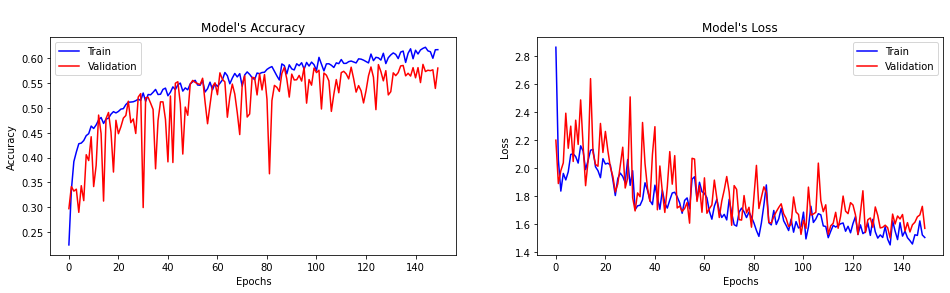

In [40]:
#plotting graphs for accuracy 
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.plot(trainedEmotionsClassiferModel2.history['categorical_accuracy'], 'b-')
plt.plot(trainedEmotionsClassiferModel2.history['val_categorical_accuracy'], 'r-')
plt.title("\nModel's Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

plt.subplot(1,2,2)
plt.plot(trainedEmotionsClassiferModel2.history['loss'], 'b-')
plt.plot(trainedEmotionsClassiferModel2.history['val_loss'], 'r-')
plt.title("\nModel's Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()

In [41]:
# model = tf.keras.models.load_model("emotionsClassifierModel.h5")

predictions = emotionsClassifier2.predict_classes(featuresTestX)

predicted = to_categorical(predictions, 7)

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(labelTestY, predicted)

# precision tp / (tp + fp)
precision = precision_score(labelTestY, predicted, average="weighted")

# recall: tp / (tp + fn)
recall = recall_score(labelTestY, predicted, average="weighted")

# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(labelTestY, predicted, average="weighted")

# ROC AUC
auc = roc_auc_score(labelTestY, predicted, average="weighted")

print("\nPrediction Test Accuracy: %f" % accuracy)
print('Precision: %f' % precision)
print('Recall: %f' % recall)
print('F1 score: %f' % f1)
print('ROC AUC: %f\n' % auc)


Prediction Test Accuracy: 0.581505
Precision: 0.583636
Recall: 0.581505
F1 score: 0.563068
ROC AUC: 0.745324




Found '3339' Labels which are Predicted Correctly



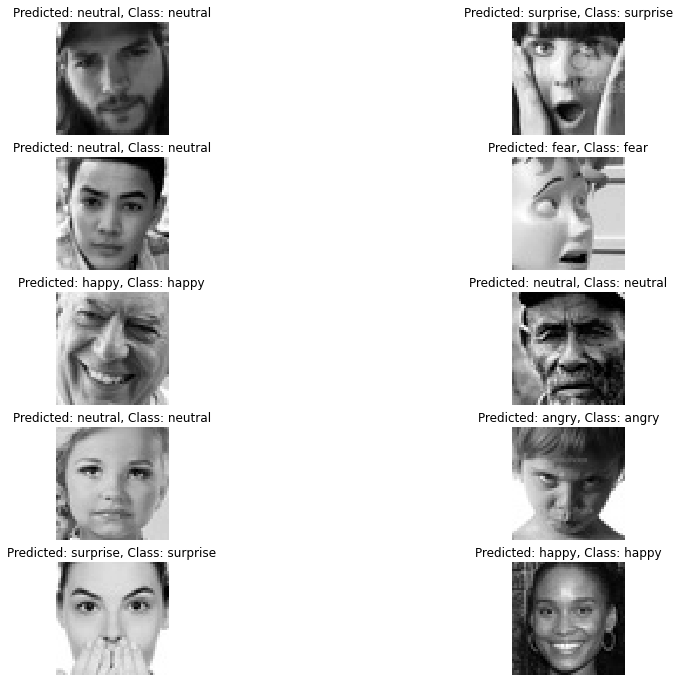

In [42]:
multilabelPrediction = np.argmax(np.round(predicted), axis=1)
multilabelTestY = np.argmax(np.round(labelTestY), axis=1)

correct = np.where(multilabelPrediction == multilabelTestY)[0]
print("\nFound '%d' Labels which are Predicted Correctly\n" % len(correct))

plt.figure(figsize=(15,12))
for i, correct in enumerate(correct[:10]):
    plt.subplot(5, 2, i+1)
    plt.imshow(featuresTestX[correct].reshape(48,48), cmap='gray', interpolation='none')
    plt.title("Predicted: {}, Class: {}".format(CATEGORIES[multilabelTestY[correct]], CATEGORIES[multilabelPrediction[correct]]))
    plt.axis('off')


Found '2403' Labels which are Predicted Incorrectly



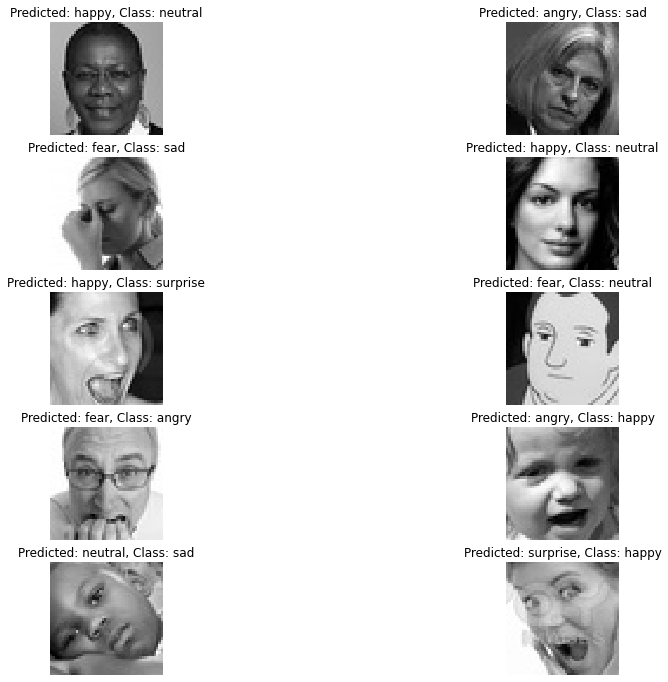

In [43]:
incorrect = np.where(multilabelPrediction != multilabelTestY)[0]
print("\nFound '%d' Labels which are Predicted Incorrectly\n" % len(incorrect))

plt.figure(figsize=(15,12))
for i, incorrect in enumerate(incorrect[:10]):
    plt.subplot(5, 2, i+1)
    plt.imshow(featuresTestX[incorrect].reshape(48,48), cmap='gray', interpolation='none')
    plt.title("Predicted: {}, Class: {}".format(CATEGORIES[multilabelTestY[incorrect]], CATEGORIES[multilabelPrediction[incorrect]]))
    plt.axis('off')

In [44]:
classification_metrics = classification_report(multilabelTestY, multilabelPrediction, target_names=CATEGORIES)
print(classification_metrics)

              precision    recall  f1-score   support

       angry       0.53      0.46      0.49       820
     disgust       0.62      0.29      0.40        85
        fear       0.55      0.17      0.26       828
       happy       0.72      0.84      0.77      1443
     neutral       0.52      0.61      0.56      1015
         sad       0.42      0.56      0.48       943
    surprise       0.74      0.72      0.73       608

    accuracy                           0.58      5742
   macro avg       0.59      0.52      0.53      5742
weighted avg       0.58      0.58      0.56      5742




Confusion matrix, without normalization

[[ 370    9   67   65  104  162   43]
 [  16   36    8    2    2   18    3]
 [  80    4  299   31   81  220  113]
 [  62    3   50 1087  105   89   47]
 [  76    1   61   87  534  221   35]
 [  94    2   89   46  144  546   22]
 [  15    0   44   24   19   21  485]]


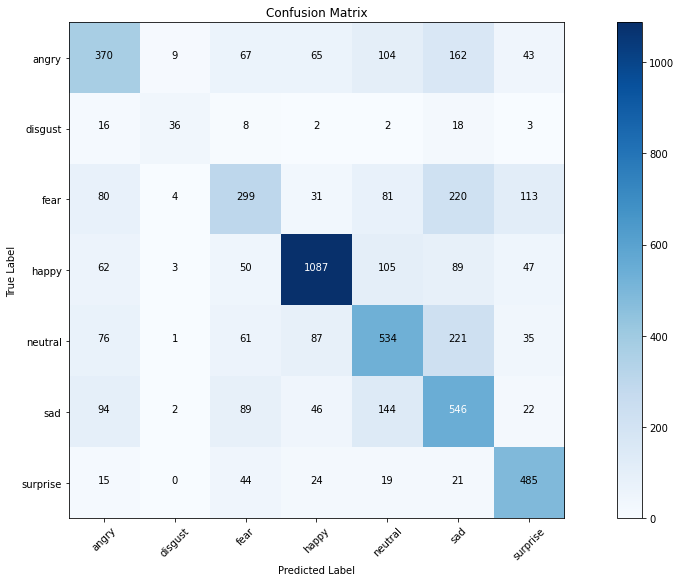

In [45]:
plot_confusion_matrix(cm, CATEGORIES, title="Confusion Matrix")